In [1]:
'''This notebook should generate Supplementary Figure ?, 
which shows how Kimura's selection coefficient compares to our selection coefficient
and the expected selection coefficient (including drop in mean fitness and homozygous).
These results are theoretical in nature.'''

"This notebook should generate Supplementary Figure ?, \nwhich shows how Kimura's selection coefficient compares to our selection coefficient\nand the expected selection coefficient (including drop in mean fitness and homozygous).\nThese results are theoretical in nature."

In [2]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
plt = mpl.pyplot
#from matplotlib import pyplot as plt
import seaborn as sns
import sys
sys.path.append("./../") # adds parent directory to path
import stationary_distribution_aug as sd
import mutator_classes as mc
from copy import deepcopy
from collections import namedtuple as nt
from scipy import stats
import pickle
from collections import defaultdict as ddict

In [3]:
get_phi = lambda S,p: S/(4*p.N*p.h*p.s*p.loci)
default_param_dict = {'mutation_rate': 1.25E-7/2, 'h': 1, 's': 0.005, 'mutator_mutation_rate': 1.25E-7, 'M': 1000, 'phi': 1,'N': 2000, 'loci': 3E8*0.08}
p = mc.Parameters(**default_param_dict)

In [4]:
def get_KIMURA_SD(p,sm=0,maxint=1000):

    zero_transition_prob = 0
    one_transition_prob  = 0

    two_loci_mu = (1 - np.exp(-p.loci * 2 * p.phi * p.s * p.h))

    for i in np.linspace(1, 2 * p.N - 1, 2 * p.N - 1):
        transition_prob_0, transition_prob_1, selection_prob = get_probability_of_transition(p, i / (2 * p.N),
                                                                                             two_loci_mu)
        zero_transition_prob += transition_prob_0
        one_transition_prob  += transition_prob_1

    zero_transition_prob = zero_transition_prob / (1 - stats.binom.pmf(0, 2 * p.N, p.mutator_mutation_rate))
    one_transition_prob  = one_transition_prob / (1 - stats.binom.pmf(0, 2 * p.N, p.mutator_mutation_rate))
    nc = zero_transition_prob + one_transition_prob + sum(
        freq_dep(i / (2 * p.N), p, two_loci_u=two_loci_mu) for i in
        np.linspace(1, 2 * p.N - 1, 2 * p.N - 1))

    sd = {0: zero_transition_prob / nc}
    for i in np.linspace(1, 2 * p.N - 1, 2 * p.N - 1):
        sd[i / (2 * p.N)] = freq_dep(i / (2 * p.N), p, two_loci_u=two_loci_mu) / nc
    sd[1] = one_transition_prob / nc

    return sd


def get_probability_of_transition(p, initial_state, two_loci_u):

    constant = freq_dep(initial_state, p, two_loci_u)

    selection_prob = 1 - two_loci_u

    zero_transition_prob = stats.binom.pmf(0, int(2 * p.N), selection_prob * initial_state) * \
                           stats.binom.pmf(0, int((1 - initial_state) * 2 * p.N), p.mutator_mutation_rate)

    one_transition_prob = stats.binom.pmf(int(2 * p.N), int(2 * p.N),selection_prob * initial_state) * \
                          stats.binom.pmf(0, int((initial_state) * 2 * p.N), p.mutator_mutation_rate)

    return zero_transition_prob * constant, one_transition_prob * constant, selection_prob


def freq_dep(x, p, two_loci_u):
    s = two_loci_u
    u = p.mutator_mutation_rate
    f = np.exp(-4 * p.N * s * x) * (x * (1 - x)) ** (4 * p.N * u - 1)

    return f

In [5]:
selections = {}
temp_params = deepcopy(default_param_dict)
results = {}

for i,S in enumerate(np.logspace(-2,4,50)):
    p.phi = get_phi(S,default_param_dict)
    
    statdist = sd.get_SD(p)
    our_mean_freq = sum(j*k for j,k in statdist.items())
    our_fixation = statdist[1]
    
    cum_survival = sd.expected_extra_mutations_somatic(p=p,phi = p.phi, max_gen = 1000)
    us = (1 - sum(cum_survival[1:])/sum(cum_survival[:-1]))
    us_avg = us*(1-our_mean_freq)
    avg_change_due_to_selection_us = sum([(k*(1-k)**2*us)*v for k,v in statdist.items()])
    print(our_mean_freq,us)
    
    kimura_statdist = get_KIMURA_SD(p)
    kimura_mean_freq = sum(j*k for j,k in kimura_statdist.items())
    kimura_fixation = kimura_statdist[1]
    kimura = (1 - np.exp(- p.loci * 2 * p.phi * p.s * p.h))
    avg_change_due_to_selection_kimura = sum([(k*(1-k)*kimura)*v for k,v in statdist.items()])
    
    selections[S] = (kimura,us,us_avg)
    results[S] = [our_mean_freq,kimura_mean_freq,temp_params['phi'],(kimura_fixation,our_fixation),(avg_change_due_to_selection_kimura,avg_change_due_to_selection_us)]
    

0.49503844663566704 2.4949856611833354e-06
0.4934226327419786 3.30762681621799e-06
0.49128079072545106 4.3849513758909e-06
0.4884419095474652 5.813167417212384e-06
0.48467968768132214 7.706560209430613e-06
0.4796950542054968 1.021663594125144e-05
0.4730936876710268 1.354424264665699e-05
0.46435780469588733 1.7955637262589974e-05
0.45281241704876174 2.3803782750020375e-05
0.43758894231897016 3.155657633679976e-05
0.4175957527646222 4.1834262119122556e-05
0.39152044581173556 5.5459011792047264e-05
0.35791977064995084 7.352062306886786e-05
0.31550703879512076 9.746356081585805e-05
0.26380723910926235 0.00012920224778201206
0.20430804629543897 0.0001712737246386542
0.1417963321824425 0.00022703970082027514
0.08450724464046494 0.00030095380370298574
0.04114037279099438 0.0003989147347378541
0.015540831244657634 0.0005287323070627403
0.004394353999134034 0.0007007411914506934
0.0009832939367221912 0.0009286067282193722
0.00024972307738684534 0.0012303781750768739
0.00011001024878644414 0.001

In [7]:
def standard_error(i,n):
    return i/(n**0.5)

result_tuple = nt('result_tuple',['s','mean','mean_err','variance','variance_err','within','within_err','phi'])

def create_result_tuple_obs(l):
    
    return result_tuple(s = l[0],
                        mean=l[1],
                        mean_err = l[2],
                        variance = l[3],
                        variance_err = l[4],
                        within = l[5],
                        within_err = l[6],
                        phi = l[7])

def get_s(p):
    s = 4*p.N*p.h*p.s*p.loci*p.phi
    return s

def process_obs(a,rdict):
    p = list(a.keys())[0]
    
    s = get_s(p)
    
    m = p.M
        
    
    values = list(a.values())[0][4][p]['var']
    
    ind_values = []
    sd_variance = []
    mean_variance = []
    within_variance = []
    for i in values:
        ind_values.extend(i)
        sd_variance.append(np.var(i))
        within_variance.append(np.mean([j*(1-j) for j in i])*2)
        mean_variance.append(np.mean(i))
        
    
    ind_values = np.array(ind_values)
    num_trials = len(values)
        
    mean = np.mean(ind_values)
    mean_err = standard_error(np.std(mean_variance),num_trials)
    
    variance = np.var(ind_values)
    variance_err = standard_error(np.std(sd_variance),num_trials) 
    
    within = np.mean(ind_values*(1-ind_values)*2)
    within_err = standard_error(np.std(within_variance),num_trials)
    
    results = create_result_tuple_obs([s,
                                       mean,
                                       mean_err,
                                       variance,
                                       variance_err,
                                       within,
                                       within_err,
                                       p.phi])
    print(p.mutation_rate)
    rdict[s] = results

in_dir = '/Users/will_milligan/PycharmProjects/Mutator_Project/Final Figs/scaled_sim_results/DEFAULT'
files = os.listdir(in_dir)

results_obs = ddict(dict)
for name in files:
    with open(name,'rb') as fin:
        a = pickle.load(fin)
    process_obs(a,results_obs)

NameError: name 'cf' is not defined

In [9]:
sns.set_style('whitegrid')

mpl.rcParams['figure.dpi'] = 400
font_size = 10
mpl.rcParams['axes.titlesize'] = font_size
mpl.rcParams['axes.labelsize'] = font_size
mpl.rcParams['xtick.labelsize'] = font_size
mpl.rcParams['ytick.labelsize'] = font_size
mpl.rcParams['legend.fontsize'] = font_size

red = [0.9,0.2,0.2]

def common_axes_modifications(ax,xlabel='',ylabel='',title=''):
    plt.sca(ax)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel,labelpad=0)
    plt.title(title,pad=7)
    plt.tick_params(bottom=True, top=False, left=True, right=False,which='both')
    plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    
    plt.grid(markevery=1)
    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color('k')
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_color('k')
    plt.xticks(ticks = np.logspace(-2,3,6),
               labels = [r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$',r'$10^{1}$',r'$10^{2}$',r'$10^{3}$'])

In [10]:
def comparison_of_mean_figure(ax,selection,results,results_obs):
    
    x_values = np.sort(list([i for i in selections.keys() if i <= 1000]))
    phi_values = np.array([results[i][2] for i in x_values])
    k_values = np.array([results[i][1] for i in x_values])*phi_values*2
    u_values = np.array([results[i][0] for i in x_values])*phi_values*2

    
    ox_values = np.sort(np.array(list(results_obs.keys())))
    oy_values = np.array([results_obs[i].mean*results_obs[i].phi*2 for i in ox_values])
    oe_values = np.array([2*results_obs[i].mean_err*results_obs[i].phi*2 for i in ox_values])

    common_axes_modifications(ax,
                              xlabel = r'Scaled selection parameter $\left(4NLhs\phi\right)$',
                              ylabel = 'Expected increase in mean rate',
                              title = r"$\bf{B.}$ Expected increase in mean mutation rate")
    ax.plot(x_values,                            
             k_values,
             ls='-',
             color='black',
             lw=2,
             zorder=1)

    ax.plot(x_values,
             u_values,
             ls='-',
             color=red,
             lw=2,
             zorder=2)

    ax.errorbar(ox_values,
                 oy_values,
                 oe_values,
                 ls='None',
                 zorder=3,
                 marker='o',
                 markersize=3,
                 mfc='k',
                 color='k')
    
    plt.errorbar([],[],[],
                 ls = 'None',
                 color='k',
                 label=' Simulated\n'+r'Mean $\pm$ 2SE',
                 marker='o',
                 markersize=3)
    
    ax.legend(loc='upper right',
              handletextpad=0,
              framealpha = 1,handlelength=1,
              edgecolor = 'k',
              borderpad = 0.2)

    twin_axes_stuff(ax1=ax.twiny(),selections=selections,p=p,k_values=k_values)

def fixation_density(ax,selections):
    
    min_value = 0.009
    max_value = 1000.01
    x_values = np.sort(list(selections.keys()))
    k_values = np.array([selections[i][-1][0] for i in x_values if i < max_value and i > min_value])
    u_values = np.array([selections[i][-1][1] for i in x_values if i < max_value and i > min_value])
    x_values = np.array([i for i in x_values if i < max_value and i > min_value])

    ax.plot(x_values,k_values,ls='-',color='black',lw=2)
    ax.plot(x_values,u_values,ls='-',color=red,lw=2)
    
    common_axes_modifications(ax = ax,
                              xlabel = r'Scaled selection parameter $\left(4NLhs\phi\right)$',
                              ylabel = r'Expected decrease per generation',
                              title = r'$\bf{A.}$ Expected decrease in mutator frequency')

    twin_axes_stuff(ax1=ax.twiny(),selections=selections,p=p,k_values=k_values)
    
def twin_axes_stuff(ax1,selections,p,k_values):
   
    ax1_x_values = np.sort(list([i for i in selections.keys() if i <= 1000]))/(2*p.N)
    
    ax1.plot(ax1_x_values,k_values,color=[0,0,0,0])
    ax1.grid(False)
    ax1.set_xscale('log')
    ax1.set_xticks(np.logspace(-5,-1,5))
    ax1.set_xlabel(r'Selection parameter ($2Lhs\phi$)')
    ax1.spines['bottom'].set_color('k')
    ax1.spines['top'].set_color('k')
    ax1.spines['left'].set_color('k')
    ax1.spines['right'].set_color('k')

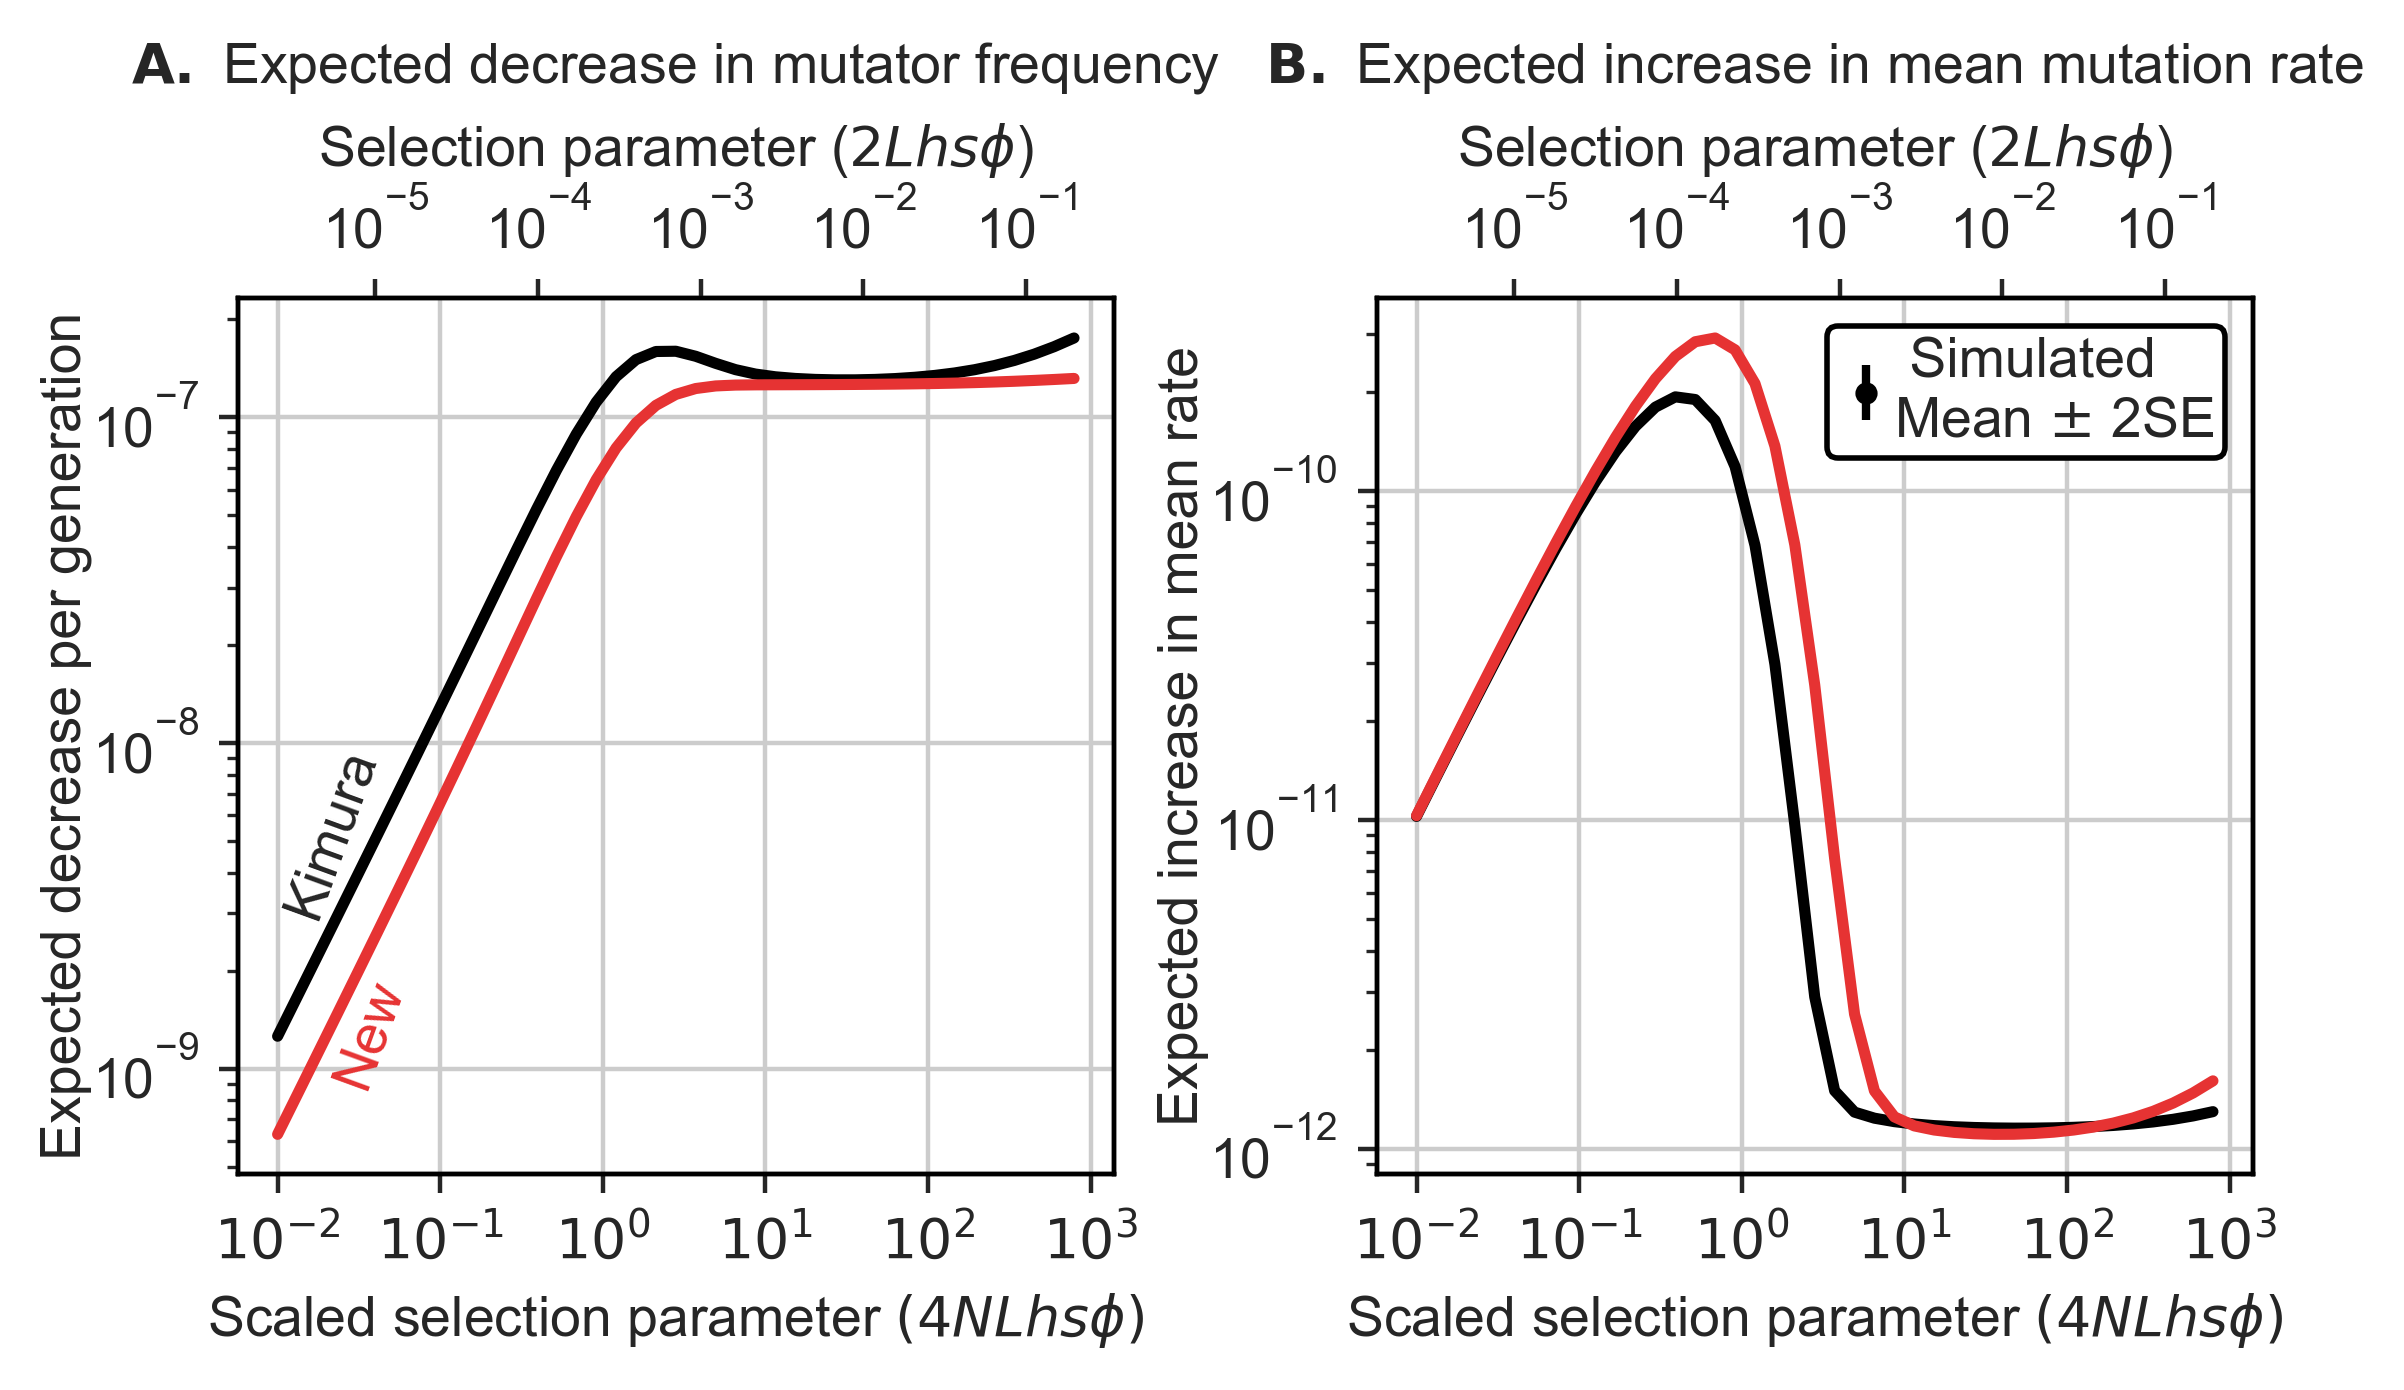

In [11]:
fig, (ax1,ax2) = plt.subplots(figsize = (6.5,3.57*6.5/8),ncols=2,nrows = 1)

fixation_density(ax1,results)
comparison_of_mean_figure(ax2,selections,results,results_obs)
ax1.text(x = 1e-2,y= 3e-9, s = "Kimura",rotation = 70, size = font_size)
ax1.text(x = 2e-2,y= 9e-10, s = 'New',rotation = 70,color=red, size = font_size)
plt.subplots_adjust(wspace=0.3,hspace=0.45)